# Ensembling Machine Learning Methods
The goal of this notebook is to combine the XGBoost predictions with different ML predictors, ensembling the two to (hopefully) create a more robust answer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trainData = pd.read_csv('../data/1e7data_train.csv', index_col=0)
testData = pd.read_csv('../data/1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData
df.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,norm_min_e2,norm_min_window10_e2,norm_min_e3,norm_min_window10_e3,norm_min_inc1,norm_min_window10_inc1,norm_min_inc2,norm_min_window10_inc2,norm_min_inc3,norm_min_window10_inc3
Sim_ID,,,,,,,,,,,,,,,,,,,,,
4465,True,1.000000e+07,10000000.0,0.000015,0.021544,0.049234,0.010924,0.011821,2.166832,0.011453,...,0.000584,0.025326,0.000058,0.010939,0.000067,0.000212,0.000205,0.001258,0.002236,0.004439
4231,False,5.556366e+05,10000000.0,0.000015,0.021544,0.043888,0.009194,0.004916,-1.426257,0.007699,...,0.000374,0.155129,0.000066,0.002199,0.000106,0.000375,0.000007,0.034136,0.000070,0.000463
487,False,1.955824e+06,10000000.0,0.000015,0.021544,0.056372,0.013384,0.006294,-0.410190,0.003253,...,0.000039,0.023756,0.000583,0.002526,0.000630,0.003254,0.000256,0.000608,0.000759,0.000256
2210,False,4.607903e+03,10000000.0,0.000015,0.021544,0.054535,0.012735,0.007372,-1.748617,0.015612,...,0.000702,0.005107,0.000400,0.006366,0.005785,0.000889,0.000212,0.000663,0.000126,0.000314
4390,True,1.000000e+07,10000000.0,0.000015,0.021544,0.042994,0.008915,0.009054,2.988464,0.013263,...,0.000565,0.008115,0.000088,0.010731,0.000342,0.000861,0.000082,0.001282,0.000835,0.000491


## Which features?
Decide on the features here. On the one hand, you can just try all the features like in XGBoost. Or, you can try just the top features from XGBoost. Or, make your own.

In [3]:
#features = ['avg_a1', 'std_a1', 'max_a1', 'min_a1', 'norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1', 'avg_a2', 'std_a2', 'max_a2', 'min_a2', 'norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'avg_a3', 'std_a3', 'max_a3', 'min_a3', 'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 'avg_e1', 'std_e1', 'max_e1', 'min_e1', 'norm_std_e1', 'norm_max_e1', 'norm_std_window10_e1', 'norm_max_window10_e1', 'avg_e2', 'std_e2', 'max_e2', 'min_e2', 'norm_std_e2', 'norm_max_e2', 'norm_std_window10_e2', 'norm_max_window10_e2', 'avg_e3', 'std_e3', 'max_e3', 'min_e3', 'norm_std_e3', 'norm_max_e3', 'norm_std_window10_e3', 'norm_max_window10_e3', 'daOvera1', 'daOvera2', 'daOverRH1', 'daOverRH2', 'mindaOvera', 'maxdaOvera', 'mindaOverRH', 'maxdaOverRH']
features = ['max_a2','std_a2','mindaOverRH','maxdaOverRH','std_a3','max_e2'] #Top XGB features

y = df['Stable']
X = df[features]
X.head()

,max_a2,std_a2,mindaOverRH,maxdaOverRH,std_a3,max_e2
Sim_ID,,,,,,
2414,0.067576,0.000014,6.969123,8.989360,0.000013,0.017359
4056,0.057587,0.000090,5.095487,5.924768,0.000092,0.031996
4855,0.061434,0.000012,7.241825,8.398691,0.000008,0.011019
517,0.067004,0.000010,8.840869,8.943640,0.000009,0.013155
1520,0.054659,0.000068,5.085694,5.908519,0.000066,0.035660


# KNN Algorithm
Here we train and get prediction probabilities for KNN - I found that KNN is not as robust as SVC.

In [23]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.neighbors import KNeighborsClassifier
#model
model = KNeighborsClassifier()

#model-specific parameters
n_neighbors = np.linspace(5,100,20)
weights = ["uniform","distance"]

#grid search parameters
param_grid = dict(n_neighbors=n_neighbors, weights=["uniform","distance"])
Nfolds = 5

#perform grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='roc_auc',iid=False, cv=Nfolds)
grid.fit(df[features],df['Stable'])

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'n_neighbors': array([   5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,   45.,
         50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,   90.,
         95.,  100.]), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

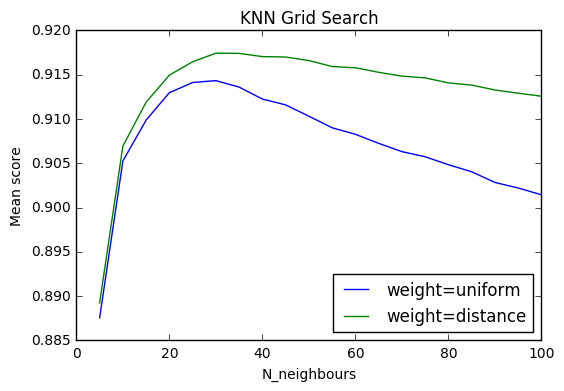

Best params are: {'n_neighbors': 30.0, 'weights': 'distance'}


In [24]:
#plot best fits of KNN n_neighbours parameter
scores = [x[1] for x in grid.grid_scores_]
scores = [x[1] for x in grid.grid_scores_]
scores_uniform = scores[::2]
scores_distance = scores[1::2]

plt.plot(n_neighbors, scores_uniform, label='weight=uniform')
plt.plot(n_neighbors, scores_distance, label='weight=distance')
plt.legend(loc='lower right')
plt.xlabel('N_neighbours')
plt.ylabel('Mean score')
plt.title('KNN Grid Search')
plt.show()

print "Best params are:",grid.best_params_

In [25]:
knnmodel = KNeighborsClassifier(n_neighbors=30, weights='distance')
knnmodel.fit(df[features],df['Stable'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

In [26]:
dtest_predprob = knnmodel.predict_proba(dftest[features])[:,1]
dftest["knn_predprob"] = dtest_predprob    #store the predicted values in the dataframe
print "AUC Score (Test): %f" % metrics.roc_auc_score(dftest['Stable'], dtest_predprob)

AUC Score (Test): 0.923910


# Support Vector Machine

In [8]:
from sklearn import svm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
#model
model = svm.SVC()

#model-specific parameters
C = np.logspace(-1,4,5)
gamma = np.logspace(1,4,5)
kernel=["rbf"]

#grid search parameters
param_grid = dict(gamma=gamma, kernel=kernel, C=C)
Nfolds = 5

#perform grid search
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='roc_auc',iid=False, cv=Nfolds)
grid.fit(df[features],df['Stable'])

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=False, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': array([  1.00000e-01,   1.77828e+00,   3.16228e+01,   5.62341e+02,
         1.00000e+04]), 'gamma': array([    10.     ,     56.23413,    316.22777,   1778.27941,  10000.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [9]:
print "Best params are:",grid.best_params_

Best params are: {'kernel': 'rbf', 'C': 562.34132519034904, 'gamma': 10.0}


In [12]:
svcmodel = svm.SVC(C=562,gamma=10.0, probability=True)
svcmodel.fit(df[features],df['Stable'])

SVC(C=562, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
dtest_predprob = svcmodel.predict_proba(dftest[features])[:,1]
dftest["svc_predprob"] = dtest_predprob    #store the predicted values in the dataframe
print "AUC Score (Test): %f" % metrics.roc_auc_score(dftest['Stable'], dtest_predprob)

AUC Score (Test): 0.932027


# Plot predicted probabilities from trained models above
This is a general purpose plotting function to visualize the predictions. Specify the pred_prob_type from one of the methods analyzed above.

In [34]:
pred_prob_type = "knn_predprob"   #choices are svc_predprob and knn_predprob right now

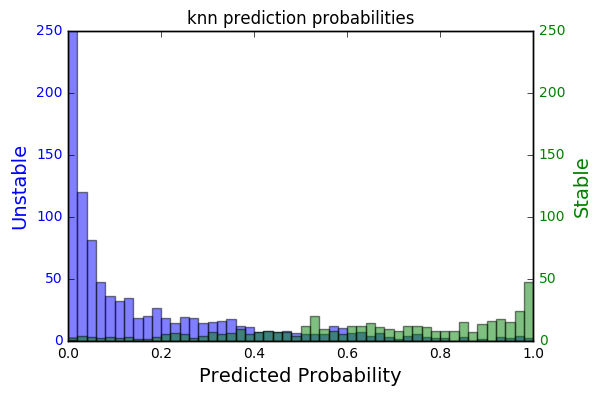

In [35]:
# Histogram:
y_pred=dftest[pred_prob_type]
bins = 50
Stable=y_pred[dftest['Stable'].values]
Unstable=y_pred[~dftest['Stable'].values]

fig, ax1 = plt.subplots()
ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
 
ax1.set_ylim([0,250])
ax2.set_ylim([0,250])
ax1.set_title("%s prediction probabilities"%pred_prob_type.split("_")[0])
plt.savefig("%s.pdf"%pred_prob_type)

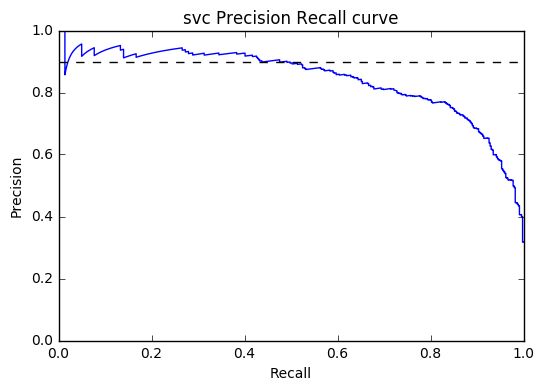

In [16]:
from sklearn.metrics import precision_recall_curve
y_pred=dftest[pred_prob_type]
precision, recall, thresholds = precision_recall_curve(dftest['Stable'], y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.plot([0,1],[0.9,0.9], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('%s Precision Recall curve'%pred_prob_type.split("_")[0])

In [17]:
for i in range(0,len(recall), 70):
    print("Threshold {0}, Precision = {1}, Recall = {2}".format(thresholds[i], precision[i], recall[i]))

Threshold 0.00036127558258, Precision = 0.317596566524, Recall = 1.0
Threshold 0.00271179044344, Precision = 0.333584337349, Recall = 0.997747747748
Threshold 0.0110695195088, Precision = 0.352146263911, Recall = 0.997747747748
Threshold 0.0248843198643, Precision = 0.372895622896, Recall = 0.997747747748
Threshold 0.0423667816817, Precision = 0.396243291592, Recall = 0.997747747748
Threshold 0.0601830022294, Precision = 0.419847328244, Recall = 0.990990990991
Threshold 0.0796646418615, Precision = 0.445807770961, Recall = 0.981981981982
Threshold 0.107420422694, Precision = 0.480176211454, Recall = 0.981981981982
Threshold 0.13181417546, Precision = 0.516706443914, Recall = 0.975225225225
Threshold 0.158831793751, Precision = 0.552083333333, Recall = 0.954954954955
Threshold 0.187134289945, Precision = 0.598853868195, Recall = 0.941441441441
Threshold 0.216745433974, Precision = 0.652866242038, Recall = 0.923423423423
Threshold 0.274999767106, Precision = 0.704301075269, Recall = 0.88

[]

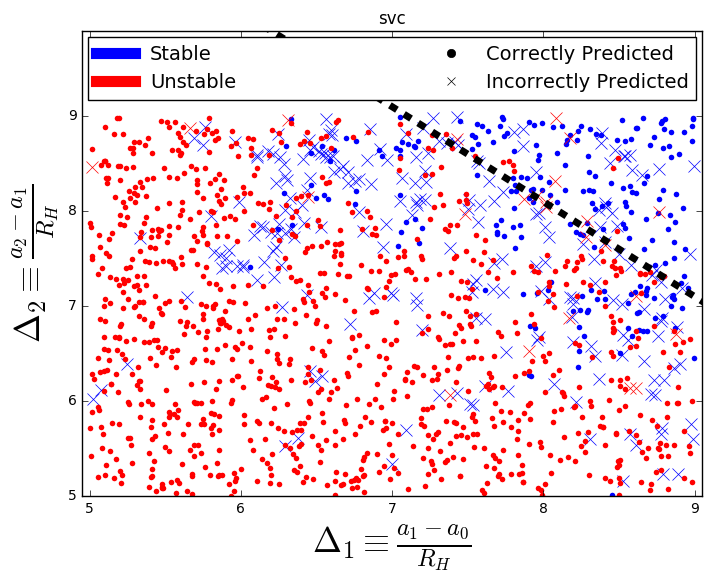

In [18]:
Stable_Thresh = 0.75    #Need the appropriate stable/unstable threshold for the corresponding pred_prob_type

Stable = dftest[dftest["Stable"]==True]
Unstable = dftest[dftest["Stable"]==False]
xaxis = "daOverRH1"
yaxis = "daOverRH2"
fontsize=25
tickfontsize=16

fig, axes = plt.subplots(figsize=(8,6))
stable_pred_color="Blue"
unstable_pred_color="Red"
axes.plot(Stable[xaxis].loc[Stable[pred_prob_type]>Stable_Thresh],Stable[yaxis].loc[Stable[pred_prob_type]>Stable_Thresh],marker="o",markersize=4,mew=0,color=stable_pred_color,linestyle="None",label="Stable, Predicted Stable")
axes.plot(Stable[xaxis].loc[Stable[pred_prob_type]<=Stable_Thresh],Stable[yaxis].loc[Stable[pred_prob_type]<=Stable_Thresh],marker="x",markersize=8,color=stable_pred_color,linestyle="None",label="Stable, Predicted Unstable")
axes.plot(Unstable[xaxis].loc[Unstable[pred_prob_type]>Stable_Thresh],Unstable[yaxis].loc[Unstable[pred_prob_type]>Stable_Thresh],marker="x",markersize=8,color=unstable_pred_color,linestyle="None",label="Unstable, Predicted Stable")
axes.plot(Unstable[xaxis].loc[Unstable[pred_prob_type]<=Stable_Thresh],Unstable[yaxis].loc[Unstable[pred_prob_type]<=Stable_Thresh],marker="o",markersize=4,mew=0,color=unstable_pred_color,linestyle="None",label="Unstable, Predicted Unstable")
miny,maxy,minx,maxx = 5,9.9,4.95,9.05
axes.set_ylim([miny,maxy])
axes.set_xlim([minx,maxx])
axes.set_xlabel(r"$ \Delta_1 \equiv \frac{a_1 - a_0}{R_H}$", fontsize=fontsize)
axes.set_ylabel(r"$ \Delta_2 \equiv \frac{a_2 - a_1}{R_H}$", fontsize=fontsize) 
#leg = axes.legend(loc="upper left",numpoints=1,fontsize=8,scatterpoints=1)

blue = plt.Line2D((0,1),(0,0), color='b', linestyle='-', linewidth=8)
red = plt.Line2D((0,1),(0,0), color='r', linestyle='-', linewidth=8)
correct = plt.Line2D(range(1), range(1), color="black", marker='o', markerfacecolor="black", linestyle='')
incorrect = plt.Line2D(range(1), range(1), color="black", marker='x', markerfacecolor="black", linestyle='')
leg = axes.legend([blue, red, correct, incorrect], ['Stable', 'Unstable', 'Correctly Predicted', 'Incorrectly Predicted'], ncol=2, numpoints=1, fontsize=14, mode="expand", borderaxespad=0.3,loc='upper right')

#Lissauer et al. (2011)
RHThresh = 16.1
x = np.arange(5,10,0.1)
axes.plot(x,RHThresh-x, 'k--', lw=5, label='$\Delta_1 + \Delta_2$=%.1f'%RHThresh)

axes.set_title(pred_prob_type.split("_")[0])
axes.plot()


# Ensembling
Here is where the actual ensembling takes place. Everything above is looking at different machine learning methods, trying to train them.

In [19]:
#now load the predicted probability values from XGBoost
data_XGBoost = pd.read_csv("ariSI.csv",header=0)
data_XGBoost.head()

,Sim_ID,daOverRH1,daOverRH2,P2/P1,P3/P2,predprob,predstable,Norbits_instability,Stable
0,1648,6.879240,7.131643,1.230348,1.239099,0.761743,False,1.000000e+07,True
1,3471,8.496936,5.371167,1.286789,1.178497,0.008978,False,8.233677e+05,False
2,3849,6.822671,5.825163,1.228390,1.194028,0.000914,False,7.204145e+03,False
3,3537,5.092680,6.103170,1.169004,1.203572,0.001462,False,5.851915e+03,False
4,4214,8.928228,5.186531,1.301979,1.172200,0.029608,False,6.435885e+06,False


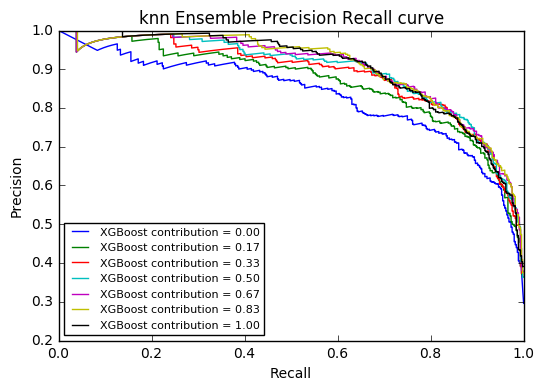

In [30]:
XGBoost_frac = np.linspace(0,1,7)
y_pred_XGB = data_XGBoost["predprob"]
y_pred_2 = dftest[pred_prob_type]
fig, ax = plt.subplots()

for f in XGBoost_frac:
    y_pred_avg = f*np.asarray(y_pred_XGB) + (1.-f)*np.asarray(y_pred_2)
    precision, recall, thresholds = precision_recall_curve(dftest['Stable'], y_pred_avg)
    ax.plot(recall, precision, label='XGBoost contribution = %.2f'%f)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left',fontsize=8)
ax.set_title('%s Ensemble Precision Recall curve'%pred_prob_type.split("_")[0])
plt.savefig("PR-%s_Ensemble.pdf"%pred_prob_type.split("_")[0])